# Magnetogram Radiative Transfer Testing

This notebook tests Surya-generated magnetograms against the radiative transfer equation using the Milne-Eddington approximation for HMI Fe I 6173.15 Å.

## Set up environment and paths

In [13]:
import os
import sys
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
# Set CUDA device (adjust based on your setup)
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

# Append paths for imports
sys.path.append("../../")
sys.path.append("../../Surya")

## Import the test function

In [2]:
from test_magnetogram_rt import test_magnetogram_rt

## Simple Single-Pixel Test

Load one image from Surya, extract Bx, By, Bz for a single pixel, and synthesize Stokes profiles (I, Q, U, V).

In [4]:
# Import utility functions
from magnetogram_utils import (
    load_magnetogram_sample,
    extract_pixel_bxyz,
    synthesize_stokes_single_pixel,
    plot_stokes_profiles
)
import yaml
from surya.utils.data import build_scalers

# Load one image from Surya dataset
config_path = "./configs/config_magnetogram_test.yaml"
print("Loading one image from Surya dataset...")
magnetogram_np, velocity_np, timestamp, dataset = load_magnetogram_sample(config_path, sample_idx=0)

print(f"\nLoaded magnetogram shape: {magnetogram_np.shape}")
print(f"  Bx range: [{magnetogram_np[0].min():.1f}, {magnetogram_np[0].max():.1f}] G")
print(f"  By range: [{magnetogram_np[1].min():.1f}, {magnetogram_np[1].max():.1f}] G")
print(f"  Bz range: [{magnetogram_np[2].min():.1f}, {magnetogram_np[2].max():.1f}] G")

if velocity_np is not None:
    print(f"  Velocity range: [{velocity_np.min():.1f}, {velocity_np.max():.1f}] m/s")
else:
    print("  Velocity: Not available")

# Print timestamp
if timestamp is not None:
    import pandas as pd
    # Convert timestamp to string (handles both pandas Timestamp and numpy datetime64)
    if isinstance(timestamp, pd.Timestamp):
        timestamp_str = timestamp.strftime('%Y-%m-%d %H:%M:%S UTC')
    elif hasattr(timestamp, 'strftime'):
        timestamp_str = pd.Timestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S UTC')
    else:
        timestamp_str = str(timestamp)
    print(f"\nTimestamp: {timestamp_str}")
else:
    print("\nTimestamp: Not available")

# Verify inverse transform: compare normalized vs inverse-transformed
print("\n" + "="*60)
print("Verifying inverse transform...")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
sample = dataset[0]
ts_normalized = sample['ts']  # [C, T, H, W] - normalized
ts_slice_normalized = ts_normalized[:, -1, :, :]  # [C, H, W] - last time step

# Get channel indices
if dataset.channels is not None:
    hmi_bx_idx = dataset.channels.index('hmi_bx')
    hmi_by_idx = dataset.channels.index('hmi_by')
    hmi_bz_idx = dataset.channels.index('hmi_bz')
else:
    hmi_bx_idx, hmi_by_idx, hmi_bz_idx = 9, 10, 11

# Check normalized values
bx_norm = ts_slice_normalized[hmi_bx_idx]
by_norm = ts_slice_normalized[hmi_by_idx]
bz_norm = ts_slice_normalized[hmi_bz_idx]

print(f"\nNormalized values (before inverse transform):")
print(f"  Bx: min={bx_norm.min():.4f}, max={bx_norm.max():.4f}, mean={bx_norm.mean():.4f}")
print(f"  By: min={by_norm.min():.4f}, max={by_norm.max():.4f}, mean={by_norm.mean():.4f}")
print(f"  Bz: min={bz_norm.min():.4f}, max={bz_norm.max():.4f}, mean={bz_norm.mean():.4f}")

print(f"\nInverse-transformed values (after inverse transform):")
print(f"  Bx: min={magnetogram_np[0].min():.1f}, max={magnetogram_np[0].max():.1f}, mean={magnetogram_np[0].mean():.1f}")
print(f"  By: min={magnetogram_np[1].min():.1f}, max={magnetogram_np[1].max():.1f}, mean={magnetogram_np[1].mean():.1f}")
print(f"  Bz: min={magnetogram_np[2].min():.1f}, max={magnetogram_np[2].max():.1f}, mean={magnetogram_np[2].mean():.1f}")

# Check if values are significantly different (inverse transform should change them)
if abs(bx_norm.min() - magnetogram_np[0].min()) > 1.0:
    print("\n✓ Inverse transform appears to be working (values changed significantly)")
else:
    print("\n⚠ Warning: Inverse transform may not be working (values are too similar)")
print("="*60)

Loading one image from Surya dataset...

Loaded magnetogram shape: (3, 4096, 4096)
  Bx range: [-1404.5, 1751.1] G
  By range: [-1687.0, 1060.4] G
  Bz range: [-1128.6, 1019.6] G
  Velocity range: [-1595.7, 5836.0] m/s

Timestamp: 2011-01-16 00:00:00 UTC

Verifying inverse transform...

Normalized values (before inverse transform):
  Bx: min=-7.9912, max=8.5961, mean=-0.0012
  By: min=-8.5675, max=7.2797, mean=-0.0174
  Bz: min=-25.5402, max=24.5940, mean=0.0035

Inverse-transformed values (after inverse transform):
  Bx: min=-1404.5, max=1751.1, mean=0.1
  By: min=-1687.0, max=1060.4, mean=-0.8
  Bz: min=-1128.6, max=1019.6, mean=0.0

✓ Inverse transform appears to be working (values changed significantly)


In [5]:
# Extract one pixel (center pixel by default, or use max field pixel)
# Set use_max_field=True to use the pixel with strongest field
Bx_pixel, By_pixel, Bz_pixel, B_mag_pixel, velocity_pixel, pixel_h, pixel_w = extract_pixel_bxyz(
    magnetogram_np, 
    velocity_np=velocity_np,  # Pass velocity data
    use_max_field=True  # Set to True to use pixel with maximum field
)

print(f"\nSelected pixel at ({pixel_h}, {pixel_w}):")
print(f"  Bx = {Bx_pixel:.1f} G")
print(f"  By = {By_pixel:.1f} G")
print(f"  Bz = {Bz_pixel:.1f} G")
print(f"  |B| = {B_mag_pixel:.1f} G")
if velocity_pixel is not None:
    from magnetogram_utils import velocity_to_lambda0
    lambda0_from_velocity = velocity_to_lambda0(velocity_pixel)
    print(f"  Velocity = {velocity_pixel:.1f} m/s")
    print(f"  lambda0 (from velocity) = {lambda0_from_velocity:.6f} Å")
else:
    print(f"  Velocity = Not available")


Selected pixel at (2739, 632):
  Bx = 1698.4 G
  By = -1187.8 G
  Bz = -611.2 G
  |B| = 2160.8 G
  Velocity = 250.2 m/s
  lambda0 (from velocity) = 0.005151 Å


In [6]:
# Synthesize Stokes profiles with constant ME parameters
# lambda0 will be computed from velocity if available, otherwise use default (0.0)
stokes_pred, wavelengths, me_params = synthesize_stokes_single_pixel(
    Bx_pixel, By_pixel, Bz_pixel,
    lambda_rest=6173.15,  # HMI Fe I line
    geff=2.5,  # Effective Landé factor
    eta0=2.0,  # Line-to-continuum opacity ratio
    dlambdaD=0.038,  # Doppler width (Angstroms)
    a=0.5,  # Damping parameter
    velocity=velocity_pixel,  # Use velocity from data to compute lambda0
    B0=1.0,  # Continuum source function
    B1=0.5,  # Line source function
    device='cuda'
)

print(f"\nME Parameters used:")
for key, value in me_params.items():
    if key in ['theta', 'chi']:
        print(f"  {key} = {value:.3f} rad ({np.degrees(value):.1f}°)")
    else:
        print(f"  {key} = {value}")

print(f"\nSynthesized Stokes profiles:")
print(f"  I: min={stokes_pred[0].min():.4f}, max={stokes_pred[0].max():.4f}, mean={stokes_pred[0].mean():.4f}")
print(f"  Q: min={stokes_pred[1].min():.4f}, max={stokes_pred[1].max():.4f}, mean={stokes_pred[1].mean():.4f}")
print(f"  U: min={stokes_pred[2].min():.4f}, max={stokes_pred[2].max():.4f}, mean={stokes_pred[2].mean():.4f}")
print(f"  V: min={stokes_pred[3].min():.4f}, max={stokes_pred[3].max():.4f}, mean={stokes_pred[3].mean():.4f}")


ME Parameters used:
  B = 2160.7977154214313
  theta = 1.858 rad (106.4°)
  chi = 2.531 rad (145.0°)
  eta0 = 2.0
  dlambdaD = 0.038
  a = 0.5
  lambda0 = 0.005151014151995203
  B0 = 1.0
  B1 = 0.5
  velocity = 250.1535186767578
  lambda0_source = velocity

Synthesized Stokes profiles:
  I: min=1.3874, max=1.4990, mean=1.4719
  Q: min=-0.0323, max=0.0147, mean=-0.0002
  U: min=-0.0441, max=0.0754, mean=-0.0016
  V: min=-0.0329, max=0.0322, mean=-0.0000


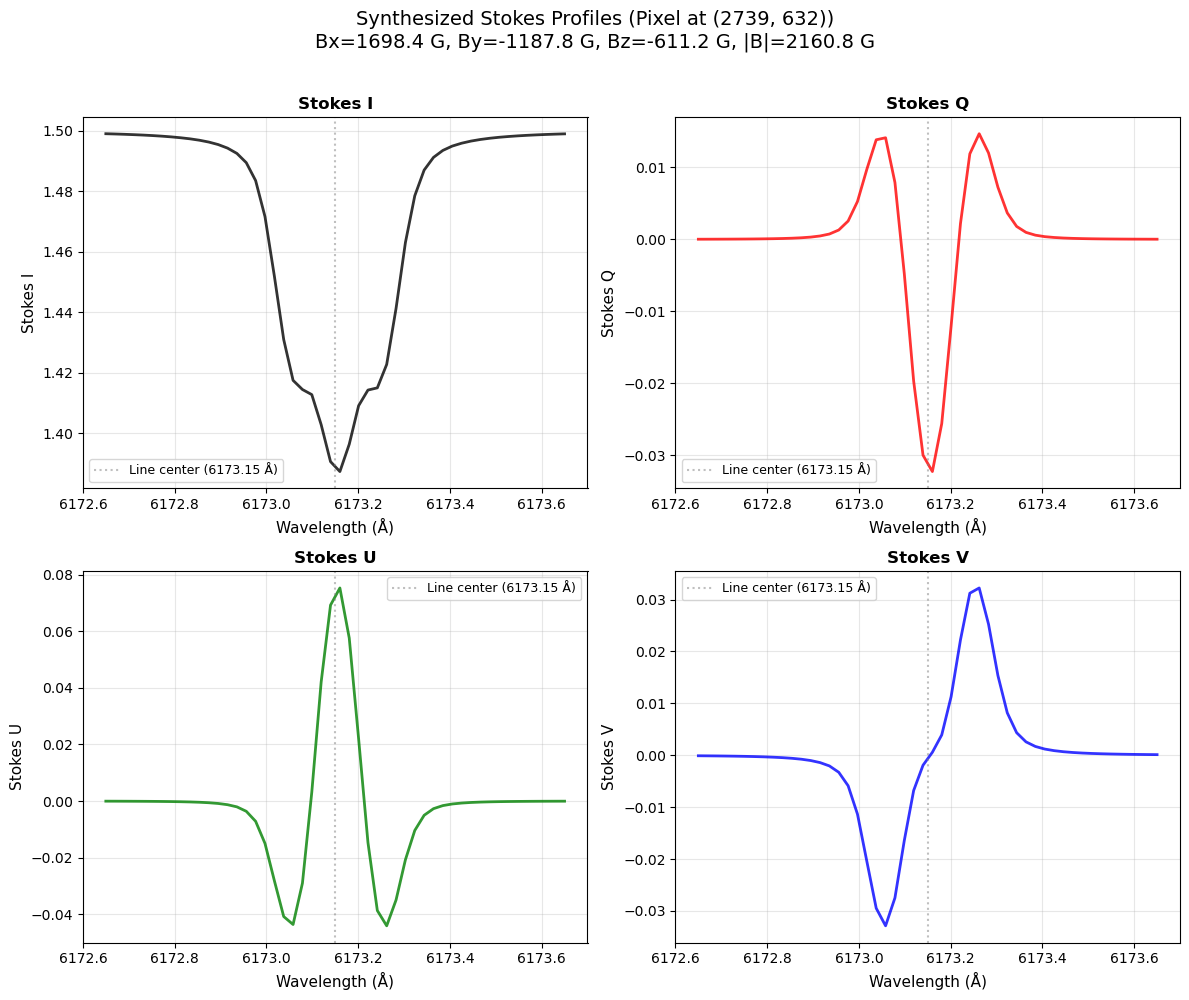

In [7]:
# Plot the synthesized Stokes profiles
plot_stokes_profiles(
    stokes_pred, 
    wavelengths, 
    Bx_pixel, By_pixel, Bz_pixel, B_mag_pixel,
    pixel_h=pixel_h, 
    pixel_w=pixel_w,
    lambda_rest=6173.15
)

# Read from the real magnetogram

Loading HMI B parameters from ./datasets/hmi.B
Timestamp: 2011-01-16 00:00:00
Pixel: (2739, 632)



Loaded HMI B parameters:
  B = 146.15 G
  Bx = 27.22 G, By = 143.49 G, Bz = 5.53 G
  theta = 87.83°, chi = 79.26°
  eta0 = 2.3500
  dlambdaD = 38.1800 mÅ
  a = 0.5000

Synthesized Stokes profiles (using real ME parameters):
  I: min=1.2776, max=1.4989, mean=1.4703
  Q: min=-0.0008, max=0.0009, mean=-0.0000
  U: min=-0.0004, max=0.0003, mean=0.0000
  V: min=-0.0007, max=0.0007, mean=-0.0000


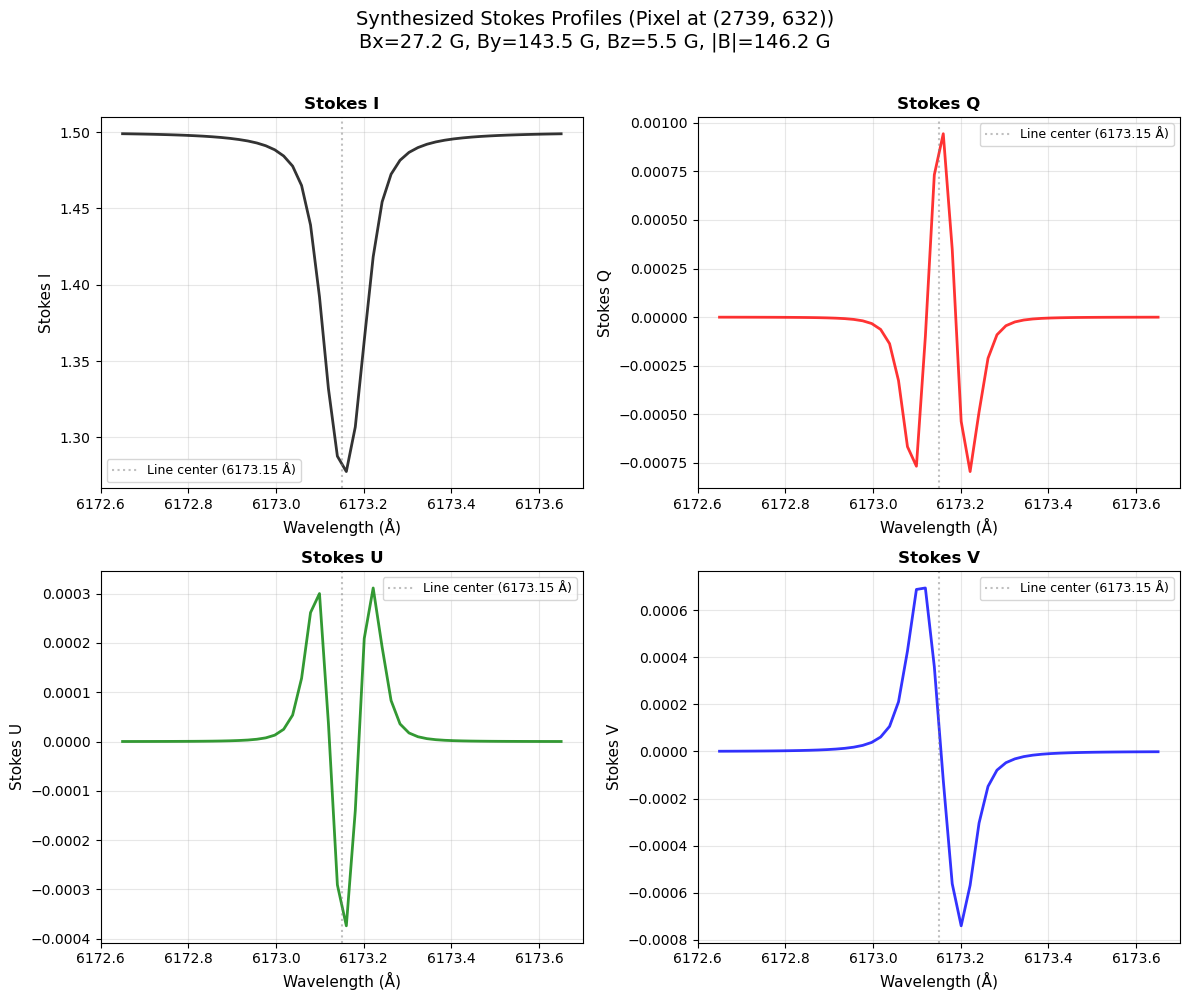

In [8]:
# Import the function to load HMI B parameters
from magnetogram_utils import load_hmi_b_parameters, synthesize_stokes_single_pixel, plot_stokes_profiles
import pandas as pd

# Load HMI B parameters from real measurements
# Use the same pixel coordinates as before (or use center pixel)
hmi_b_dir = './datasets/hmi.B'
timestamp = pd.Timestamp('2011-01-16 00:00:00')  # Match the HMI B file timestamp
pixel_h, pixel_w = 2739, 632  # Use the same pixel as before, or use None for center

print(f"Loading HMI B parameters from {hmi_b_dir}")
print(f"Timestamp: {timestamp}")
print(f"Pixel: ({pixel_h}, {pixel_w})")

# Load the real ME parameters
hmi_params, pixel_h_used, pixel_w_used = load_hmi_b_parameters(
    hmi_b_dir, 
    timestamp, 
    pixel_h=pixel_h, 
    pixel_w=pixel_w
)

print(f"\nLoaded HMI B parameters:")
print(f"  B = {hmi_params['B_mag']:.2f} G")
print(f"  Bx = {hmi_params['Bx']:.2f} G, By = {hmi_params['By']:.2f} G, Bz = {hmi_params['Bz']:.2f} G")
print(f"  theta = {np.rad2deg(hmi_params['theta']):.2f}°, chi = {np.rad2deg(hmi_params['chi']):.2f}°")
print(f"  eta0 = {hmi_params['eta0']:.4f}")
print(f"  dlambdaD = {hmi_params['dlambdaD']:.4f} mÅ")
print(f"  a = {hmi_params['a']:.4f}")

# Synthesize Stokes profiles using real ME parameters
stokes_pred_real, wavelengths_real, me_params_real = synthesize_stokes_single_pixel(
    hmi_params['Bx'], 
    hmi_params['By'], 
    hmi_params['Bz'],
    lambda_rest=6173.15,  # HMI Fe I line
    geff=2.5,  # Effective Landé factor
    eta0=hmi_params['eta0'],  # Use real eta0
    dlambdaD=hmi_params['dlambdaD']/1000.,  # Use real dop_width
    a=hmi_params['a'],  # Use real damping
    velocity=velocity_pixel,  # Assume no velocity shift (can be updated if velocity data available)
    B0=1.0,  # Continuum source function
    B1=0.5,  # Line source function
    device='cuda'
)

print(f"\nSynthesized Stokes profiles (using real ME parameters):")
print(f"  I: min={stokes_pred_real[0].min():.4f}, max={stokes_pred_real[0].max():.4f}, mean={stokes_pred_real[0].mean():.4f}")
print(f"  Q: min={stokes_pred_real[1].min():.4f}, max={stokes_pred_real[1].max():.4f}, mean={stokes_pred_real[1].mean():.4f}")
print(f"  U: min={stokes_pred_real[2].min():.4f}, max={stokes_pred_real[2].max():.4f}, mean={stokes_pred_real[2].mean():.4f}")
print(f"  V: min={stokes_pred_real[3].min():.4f}, max={stokes_pred_real[3].max():.4f}, mean={stokes_pred_real[3].mean():.4f}")

# Plot the synthesized Stokes profiles
plot_stokes_profiles(
    stokes_pred_real, 
    wavelengths_real, 
    hmi_params['Bx'], 
    hmi_params['By'], 
    hmi_params['Bz'], 
    hmi_params['B_mag'],
    pixel_h=pixel_h_used, 
    pixel_w=pixel_w_used,
    lambda_rest=6173.15
)